# 量化投资第一次作业
**作者：** 黄倪远

**学号：** 3200101028

**班级：** 金融学2003


----


1.	原始代码为静态训练，可否改成滚动训练，如每次使用最近N个月数据训练，每半年更新一次模型？（提示：增加循环即可）
    * 在Para类中增加`scroll_interval`和`scroll_times`表示滚动的间隔和滚动的次数在之后的训练中增加大循环以实现更新模型的目的。


2.	原始代码未涉及交叉验证调参，验证集未实际发挥作用，可否添加调参模块？（提示：sklearn有现成工具）
    * 改用k-Folder交叉检验方法；
    * 在Para类中定义`evaluation_metrics`来表示检验的方法，`cv`来表示K值；
        * 具体代码见第五个代码块的第109-122行
    * 利用网络搜索进行调参
        * 具体代码见第五个代码块的第124-203行（由于运行时间太长，把这部分代码注释掉了）


3.	原始代码仅使用单一模型训练，其他机器学习方法表现如何，这些方法内部相关性如何？可否对低相关模型进行集成，进一步提升表现？（提示：绝大部分方法sklearn有现成工具；神经网络可使用tf、pytorch等编写，有一定难度）
    * 采用Mean Squared Error、Median Absolute Error、R方作为衡量内部相关性的指标；
        * 具体代码见第五个代码块的第205-218行；
    * 在第四个代码块中定义了别的模型：KNN、SVM、Logistic Regression(LR)、Random Forest；
    * 在第六个代码块之后，尝试搭建了一下模型融合的方法，由于运行耗时实在太大，没有能将结果输出，可能中间的代码细节有诸多纰漏，大致思路如下：
        * 借鉴k-FOLDER的思路，来决定不同模型之间的决策边界；
        * 再利用多个模型的结果进行投票产生结果。
        



4.	原始策略在2017年后经历了较长的超额收益回撤（相对沪深300），可能是什么原因？有什么方法可以改进？  

    该模型本质上是基于历史经验信息，对未来市场的预测本身就存在一定的风险，而在2017年之后的较大回撤可能有以下的原因：
    * 训练集的各个样本在时间维度上是等权的，这显然不符合股市中时间越近影响越大的实际场景。可以在模型中加入时间尺度，给时间设置权重参数或者使用时间序列学习模型；
    * 模型的准确率仍然较低。模型存在很大改进空间，提升Xgboost损失函数精度，准确的将错分类的惩罚力度区分开来。
    * 对模型中使用的因子不够全面。给模型中加入更多稳健的因子，以解决模型在部分年份失效的问题。
    

In [1]:
## 第一题：滚动训练：如每次使用最近N个月数据训练，每半年更新一次模型
import numpy as np
import pandas as pd

In [2]:
## 定义参数类
#-- define a class including all parameters
class Para():
    
    method = 'XGBOOST-C' # 'LOGI' 'XGBOOST-C' 'LR'
    month_in_sample = range(82,144+1) #-- return 82~144 63 months（样本内）
    month_test = range(145,269+1) #-- return 145~269 125 months（样本外）
    
    scroll_interval = 6 #每隔6个月更新一次
    scroll_times = range(0,4) #总共更新了4次
    
    evaluation_metrics = 'cross_val_score' #'cross_val_score' 'cross_validate'
    cv = 5 # k value in k-folder
    
    percent_select = [0.3,0.3] #-- 30% positive samples, 30% negative samples
    percent_cv = 0.1 #-- percentage of cross validation samples （交叉验证样本的百分比）
    
    path_data = './data/csv_demo/'
    path_results = './results/'
    
    seed = 42 #-- random seed
    
    logi_c = 0.0006 #-- logistic regression parameter
    
    xgbc_n_estimators = 100 #-- xgboost classifier parameter
    xgbc_learning_rate = 0.1 #-- xgboost classifier parameter
    xgbc_subsample_C = 0.95 #-- xgboost classifier parameter
    xgbc_max_depth = 3 #-- xgboost classifier parameter

In [3]:
## 生成二分类标签函数
#-- function, label data 
def label_data(data):
    #-- label data
    data['return_bin'] = np.nan #nan就是NAN，缺失值
    
    #-- sort by return
    data = data.sort_values(by='return',ascending=False) #按照return字符对数据进行降序排序
    
    #-- decide the amount of stocks selected
    n_stock_select = np.multiply(para.percent_select,data.shape[0]) #求内积：para.percent_select=[0.3,0.3]是选择的百分比 shape[0]应该是样本总量
    n_stock_select = np.around(n_stock_select).astype(int) #取整
    
    #-- assign 1 or 0 在最后加一列，前百分之30赋1 后百分之30赋0
    data.iloc[0:n_stock_select[0],-1] = 1
    data.iloc[-n_stock_select[1]:,-1] = 0
    
    #-- remove other stocks
    data = data.dropna(axis=0)
    
    return data


In [ ]:
def knn_module(x,y,indices, c_param, bdry=None):
    knn=KNeighborsClassifier(n_neighbors=c_param)
    knn.fit(x.iloc[indices[0],:], y.iloc[indices[0],:].values.ravel())
    y_pred_undersample = knn.predict(x.iloc[indices[1],:].values)
    
    return y_pred_undersample
    
def svm_rbf_module(x, y, indices, c_param, bdry= 0.5):
    svm_rbf = SVC(C=c_param, probability=True)
    svm_rbf.fit(x.iloc[indices[0],:], y.iloc[indices[0],:].values.ravel())
    y_pred_undersample = svm_rbf.predict_proba(x.iloc[indices[1],:].values)[:,1] >= bdry
    return y_pred_undersample

def svm_poly_module(x,y, indices, c_param, bdry=0.5):
    svm_poly=SVC(C=c_param[0], kernel='poly', degree= c_param[1], probability=True)
    svm_poly.fit(x.iloc[indices[0],:], y.iloc[indices[0],:].values.ravel())
    y_pred_undersample = svm_poly.predict_proba(x.iloc[indices[1],:].values)[:,1] >= bdry
    return y_pred_undersample

def lr_module(x,y, indices, c_param, bdry=0.5):
    lr = LogisticRegression(C=c_param,penalty='11')
    lr.fit(X.iloc[indices[0],:], y.iloc[indices[0],:].values.ravel())
    y_pred_undersample= lr.predict_proba(X.iloc[indices[1],:].values)[:,1]>=bdry
    return y_pred_undersample
    
def rf_module(x,y, indices, c_param, bdry=0.5):
    rf= RandomForestClassifier(n_jobs=-1,n_estimators=100, criterion='entropy', max_features= 'auto',
                               max_depth=None,min_samples_split= c_param, random_state=0)
    rf.fit(X.iloc[indices[0],:], y.iloc[indices[0],:].values.ravel())
    y_pred_undersample = rf.predict_proba(X.iloc[indices[1],:].values)[:,1]>=bdry
    return y_pred_undersample

BASIC INFORMATION:
method = XGBOOST-C
evaluation_metrics = cross_val_score
scroll times = 4
------------------------------------

training times = 1
##----------------------------------
1.CROSS-VALIDATION:
[0.58573148 0.58901412 0.58802932 0.59787723 0.58065222]
##----------------------------------
2.INTERNAL DEPENDENCE:
Mean Squared Error(MSE) = 0.240088
Median Absolute Error(MAE) = 0.478789
R^2 score = 0.039487
##----------------------------------
3.MODOLE EVALUATION:
training set, accuracy = 0.62
training set, AUC = 0.66
cv set, accuracy = 0.58
cv set, AUC = 0.61
testing set, month 145, accuracy = 0.48
testing set, month 145, AUC = 0.48
testing set, month 146, accuracy = 0.56
testing set, month 146, AUC = 0.58
testing set, month 147, accuracy = 0.64
testing set, month 147, AUC = 0.69
testing set, month 148, accuracy = 0.51
testing set, month 148, AUC = 0.54
testing set, month 149, accuracy = 0.55
testing set, month 149, AUC = 0.58
testing set, month 150, accuracy = 0.51
testing set,

testing set, month 259, AUC = 0.56
testing set, month 260, accuracy = 0.53
testing set, month 260, AUC = 0.55
testing set, month 261, accuracy = 0.50
testing set, month 261, AUC = 0.50
testing set, month 262, accuracy = 0.48
testing set, month 262, AUC = 0.47
testing set, month 263, accuracy = 0.66
testing set, month 263, AUC = 0.72
testing set, month 264, accuracy = 0.50
testing set, month 264, AUC = 0.50
testing set, month 265, accuracy = 0.48
testing set, month 265, AUC = 0.49
testing set, month 266, accuracy = 0.50
testing set, month 266, AUC = 0.51
testing set, month 267, accuracy = 0.56
testing set, month 267, AUC = 0.59
testing set, month 268, accuracy = 0.62
testing set, month 268, AUC = 0.67
testing set, month 269, accuracy = 0.53
testing set, month 269, AUC = 0.55
##----------------------------------
4.SIMPLE STRATEGY:


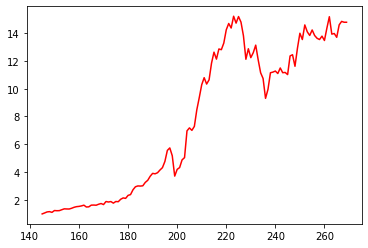

annual excess return = 0.29
annual excess volatility = 0.25
information ratio = 1.18

training times = 2
##----------------------------------
1.CROSS-VALIDATION:
[0.58173332 0.59149252 0.58714331 0.58258195 0.58328029]
##----------------------------------
2.INTERNAL DEPENDENCE:
Mean Squared Error(MSE) = 0.237957
Median Absolute Error(MAE) = 0.479588
R^2 score = 0.048162
##----------------------------------
3.MODOLE EVALUATION:
training set, accuracy = 0.61
training set, AUC = 0.66
cv set, accuracy = 0.58
cv set, AUC = 0.62
testing set, month 145, accuracy = 0.52
testing set, month 145, AUC = 0.53
testing set, month 146, accuracy = 0.56
testing set, month 146, AUC = 0.61
testing set, month 147, accuracy = 0.68
testing set, month 147, AUC = 0.76
testing set, month 148, accuracy = 0.55
testing set, month 148, AUC = 0.59
testing set, month 149, accuracy = 0.61
testing set, month 149, AUC = 0.65
testing set, month 150, accuracy = 0.55
testing set, month 150, AUC = 0.53
testing set, month 15

testing set, month 263, AUC = 0.72
testing set, month 264, accuracy = 0.50
testing set, month 264, AUC = 0.49
testing set, month 265, accuracy = 0.49
testing set, month 265, AUC = 0.50
testing set, month 266, accuracy = 0.50
testing set, month 266, AUC = 0.50
testing set, month 267, accuracy = 0.57
testing set, month 267, AUC = 0.60
testing set, month 268, accuracy = 0.62
testing set, month 268, AUC = 0.67
testing set, month 269, accuracy = 0.54
testing set, month 269, AUC = 0.55
##----------------------------------
4.SIMPLE STRATEGY:


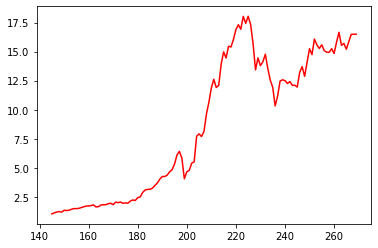

annual excess return = 0.30
annual excess volatility = 0.26
information ratio = 1.17

training times = 3
##----------------------------------
1.CROSS-VALIDATION:
[0.58739837 0.58252033 0.57729444 0.58664498 0.58125826]
##----------------------------------
2.INTERNAL DEPENDENCE:
Mean Squared Error(MSE) = 0.237326
Median Absolute Error(MAE) = 0.478151
R^2 score = 0.050422
##----------------------------------
3.MODOLE EVALUATION:
training set, accuracy = 0.61
training set, AUC = 0.66
cv set, accuracy = 0.59
cv set, AUC = 0.62
testing set, month 145, accuracy = 0.48
testing set, month 145, AUC = 0.48
testing set, month 146, accuracy = 0.55
testing set, month 146, AUC = 0.58
testing set, month 147, accuracy = 0.70
testing set, month 147, AUC = 0.77
testing set, month 148, accuracy = 0.56
testing set, month 148, AUC = 0.59
testing set, month 149, accuracy = 0.62
testing set, month 149, AUC = 0.66
testing set, month 150, accuracy = 0.52
testing set, month 150, AUC = 0.51
testing set, month 15

testing set, month 255, AUC = 0.58
testing set, month 256, accuracy = 0.45
testing set, month 256, AUC = 0.44
testing set, month 257, accuracy = 0.54
testing set, month 257, AUC = 0.56
testing set, month 258, accuracy = 0.57
testing set, month 258, AUC = 0.60
testing set, month 259, accuracy = 0.56
testing set, month 259, AUC = 0.57
testing set, month 260, accuracy = 0.52
testing set, month 260, AUC = 0.53
testing set, month 261, accuracy = 0.48
testing set, month 261, AUC = 0.49
testing set, month 262, accuracy = 0.47
testing set, month 262, AUC = 0.46
testing set, month 263, accuracy = 0.68
testing set, month 263, AUC = 0.74
testing set, month 264, accuracy = 0.46
testing set, month 264, AUC = 0.46
testing set, month 265, accuracy = 0.48
testing set, month 265, AUC = 0.48
testing set, month 266, accuracy = 0.48
testing set, month 266, AUC = 0.48
testing set, month 267, accuracy = 0.57
testing set, month 267, AUC = 0.60
testing set, month 268, accuracy = 0.62
testing set, month 268, A

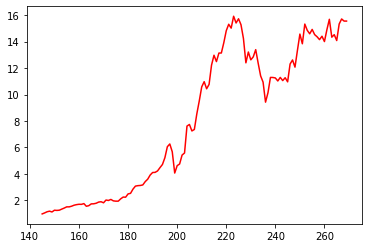

annual excess return = 0.30
annual excess volatility = 0.25
information ratio = 1.19

training times = 4
##----------------------------------
1.CROSS-VALIDATION:
[0.5835808  0.58147332 0.57141489 0.58080276 0.58219966]
##----------------------------------
2.INTERNAL DEPENDENCE:
Mean Squared Error(MSE) = 0.239671
Median Absolute Error(MAE) = 0.481484
R^2 score = 0.040891
##----------------------------------
3.MODOLE EVALUATION:
training set, accuracy = 0.61
training set, AUC = 0.65
cv set, accuracy = 0.58
cv set, AUC = 0.61
testing set, month 145, accuracy = 0.50
testing set, month 145, AUC = 0.50
testing set, month 146, accuracy = 0.57
testing set, month 146, AUC = 0.61
testing set, month 147, accuracy = 0.70
testing set, month 147, AUC = 0.76
testing set, month 148, accuracy = 0.54
testing set, month 148, AUC = 0.59
testing set, month 149, accuracy = 0.60
testing set, month 149, AUC = 0.65
testing set, month 150, accuracy = 0.52
testing set, month 150, AUC = 0.51
testing set, month 15

testing set, month 249, AUC = 0.60
testing set, month 250, accuracy = 0.60
testing set, month 250, AUC = 0.63
testing set, month 251, accuracy = 0.57
testing set, month 251, AUC = 0.61
testing set, month 252, accuracy = 0.64
testing set, month 252, AUC = 0.69
testing set, month 253, accuracy = 0.56
testing set, month 253, AUC = 0.60
testing set, month 254, accuracy = 0.61
testing set, month 254, AUC = 0.63
testing set, month 255, accuracy = 0.57
testing set, month 255, AUC = 0.60
testing set, month 256, accuracy = 0.45
testing set, month 256, AUC = 0.44
testing set, month 257, accuracy = 0.55
testing set, month 257, AUC = 0.58
testing set, month 258, accuracy = 0.57
testing set, month 258, AUC = 0.61
testing set, month 259, accuracy = 0.54
testing set, month 259, AUC = 0.56
testing set, month 260, accuracy = 0.52
testing set, month 260, AUC = 0.53
testing set, month 261, accuracy = 0.50
testing set, month 261, AUC = 0.50
testing set, month 262, accuracy = 0.46
testing set, month 262, A

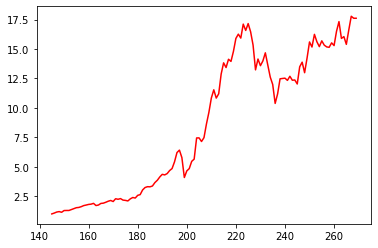

annual excess return = 0.31
annual excess volatility = 0.25
information ratio = 1.26


In [4]:
para = Para()
print("BASIC INFORMATION:")
print("method = %s"%para.method)
print("evaluation_metrics = %s"%para.evaluation_metrics)
print("scroll times = %d"%len(para.scroll_times))
print('------------------------------------')


for i_times in para.scroll_times:
    ## 生成样本内数据集
    #-- generate in-sample data
    print('')
    print("training times = %d"%(i_times+1))
    for i_month in para.month_in_sample:
        #-- load csv
        file_name = para.path_data + str(i_month+i_times*para.scroll_interval) + '.csv'
        data_curr_month = pd.read_csv(file_name, header = 0)
        para.n_stock = data_curr_month.shape[0]

        #-- remove nan
        data_curr_month = data_curr_month.dropna(axis=0)

        #-- label data    
        data_curr_month = label_data(data_curr_month)

        #-- merge
        if i_month == para.month_in_sample[0]: #-- first month
            data_in_sample = data_curr_month
        else:
            data_in_sample = pd.concat((data_in_sample,data_curr_month), axis=0)
    # 样本内数据集
    #-- generate in-sample data
    X_in_sample = data_in_sample.loc[:,'EP':'bias'] #提取出EP和bias两列的数据

    #-- classification
    if para.method in ['LOGI','XGBOOST-C']:
        y_in_sample = data_in_sample.loc[:,'return_bin']

    #-- regression
    if para.method in ['LR']:
        y_in_sample = data_in_sample.loc[:,'return']
    
    ## 划分训练集和验证集
    #-- generate train and cv data
    from sklearn.model_selection import train_test_split

    if para.percent_cv > 0:
        X_train, X_cv, y_train, y_cv = train_test_split(X_in_sample, y_in_sample, test_size=para.percent_cv, random_state=para.seed)
    else:
        X_train, y_train = X_in_sample.copy(), y_in_sample.copy()
        
     
    ## 主成分分析
    '''
    #-- pca
    from sklearn import decomposition

    pca = decomposition.PCA(n_components=0.95)
    pca.fit(X_train)
    X_train = pca.transform(X_train)

    if para.percent_cv > 0:
        X_cv = pca.transform(X_cv)
    '''

    ## 设置模型
    #-- set model

    #-- logistic regression
    if para.method == 'LOGI':
        from sklearn import linear_model
        model = linear_model.LogisticRegression(C=para.logi_c)

    #-- XGBoost Classifier
    if para.method == 'XGBOOST-C':
        from xgboost import XGBClassifier
        model = XGBClassifier(random_state=para.seed,
                              n_estimators=para.xgbc_n_estimators,
                              learning_rate=para.xgbc_learning_rate,
                              subsample=para.xgbc_subsample_C,
                              max_depth=para.xgbc_max_depth)

    #-- linear regression
    if para.method == 'LR':
        from sklearn import linear_model
        model = linear_model.LinearRegression(fit_intercept=True)
    
    ## 训练模型，交叉验证
    #-- train model, and perform cross validation
    #-- classification
    if para.method in ['LOGI','XGBOOST-C']:
        model.fit(X_train,y_train)
        #-- y_pred: binary format; y_score: continious format
        y_pred_train = model.predict(X_train) 
        y_score_train = model.predict_proba(X_train)[:,1]

        if para.percent_cv > 0:
            y_pred_cv = model.predict(X_cv)
            y_score_cv = model.predict_proba(X_cv)[:,1]

    #-- regression
    if para.method in ['LR']:
        model.fit(X_train,y_train)
        y_score_train = model.predict(X_train)

        if para.percent_cv > 0:
            y_score_cv = model.predict(X_cv)
    
    #-- 计算交叉验证的指标
    print('##----------------------------------')
    print('1.CROSS-VALIDATION:')
    if(para.evaluation_metrics == 'cross_val_score'):
        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(model,X_train,y_train,cv=5)
        print(scores)
    if(para.evaluation_metrics == 'cross_validate'):
        from sklearn.model_selection import cross_validate
        from sklearn.metrics import recall_score
        scoring = ['precision_macro', 'recall_macro']
        scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=5)
        print(sorted(scores.keys()))
        print(scores['test_recall_macro'])
    
    '''
    #-- 超参数调整
    from matplotlib import pyplot as plt
    from sklearn.datasets import make_hastie_10_2
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import make_scorer
    from sklearn.metrics import accuracy_score
    from sklearn.tree import DecisionTreeClassifier
    
    def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
        if useTrainCV:
            xgb_param = alg.get_xgb_params()
            xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
            cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                metrics='auc', early_stopping_rounds=early_stopping_rounds, show_progress=False)
            alg.set_params(n_estimators=cvresult.shape[0])

        #Fit the algorithm on the data
        alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')

        #Predict training set:
        dtrain_predictions = alg.predict(dtrain[predictors])
        dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]

        #Print model report:
        print ("\nModel Report")
        print ("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
        print ("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
        feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
    
    param_test1 = {
     'max_depth':range(1,5,1),
     'min_child_weight':range(1,6,2)
    }
    gsearch1 = GridSearchCV(
        model, 
        param_grid = param_test1,
        scoring='roc_auc',
        n_jobs=4,
        cv=5
    )
    gsearch1.fit(X_train,y_train)
    
    param_test2 = {
     'max_depth':[4,5,6],
     'min_child_weight':[2,3,4]
    }
    gsearch2 = GridSearchCV(
        model, 
        param_grid = param_test1,
        scoring='roc_auc',
        n_jobs=4,
        cv=5
    )
    gsearch2.fit(X_train,y_train)
    
    param_test3 = {
     'gamma':[i/10.0 for i in range(0,5)]
    }
    gsearch3 = GridSearchCV(
        model, 
        param_grid = param_test1,
        scoring='roc_auc',
        n_jobs=4,
        cv=5
    )
    gsearch3.fit(X_train,y_train)
    
    mode2 = XGBClassifier(random_state=para.seed,
                          n_estimators=para.xgbc_n_estimators,
                          learning_rate=para.xgbc_learning_rate,
                          subsample=para.xgbc_subsample_C,
                          max_depth=
                          min_child_weight=
                          gamma=
                          )
    
    '''
    
    #- 内部关联性分析
    print('##----------------------------------')
    print('2.INTERNAL DEPENDENCE:')
    
    from sklearn.metrics import mean_squared_error
    from sklearn.metrics import median_absolute_error
    from sklearn.metrics import r2_score

    mse = mean_squared_error(y_cv, y_score_cv)
    print("Mean Squared Error(MSE) = %.6f"%mse)
    mae = median_absolute_error(y_cv, y_score_cv)
    print("Median Absolute Error(MAE) = %.6f"%mae)
    r2 = r2_score(y_cv, y_score_cv) 
    print("R^2 score = %.6f"%r2)
    
    
    ## 样本外预测
    #-- predict
    y_true_test = pd.DataFrame([np.nan] * np.zeros((para.n_stock,para.month_test[-1])))
    y_pred_test = pd.DataFrame([np.nan] * np.zeros((para.n_stock,para.month_test[-1])))
    y_score_test = pd.DataFrame([np.nan] * np.zeros((para.n_stock,para.month_test[-1])))

    for i_month in para.month_test:
        #-- load 
        file_name = para.path_data + str(i_month) + '.csv'
        data_curr_month = pd.read_csv(file_name, header = 0)

        #-- remove nan  
        data_curr_month = data_curr_month.dropna(axis=0)

        #-- generate X
        X_curr_month = data_curr_month.loc[:,'EP':'bias']

        #-- pca
        #X_curr_month = pca.transform(X_curr_month)

        #-- predict and get predicted probability
        #-- classification
        if para.method in ['LOGI','XGBOOST-C']:
            y_pred_curr_month = model.predict(X_curr_month)
            y_score_curr_month = model.predict_proba(X_curr_month)[:,1]

        #-- linear regression
        if para.method in ['LR',]:
            y_score_curr_month = model.predict(X_curr_month)

        #-- store real and predicted return
        y_true_test.iloc[data_curr_month.index,i_month-1] = data_curr_month['return'][data_curr_month.index]
        if para.method in ['LOGI','XGBOOST-C']:
            y_pred_test.iloc[data_curr_month.index,i_month-1] = y_pred_curr_month
        y_score_test.iloc[data_curr_month.index,i_month-1] = y_score_curr_month

    ## 模型评价
    #-- evaluate
    print('##----------------------------------')
    print('3.MODOLE EVALUATION:')
    if para.method in ['LOGI','XGBOOST-C']:
        output_acc_auc = pd.DataFrame([np.nan] * np.zeros((para.month_test[-1],6)))

        from sklearn import metrics

        print('training set, accuracy = %.2f'%metrics.accuracy_score(y_train, y_pred_train))
        print('training set, AUC = %.2f'%metrics.roc_auc_score(y_train, y_score_train))
        output_acc_auc.iloc[para.month_in_sample[-1]-1,0] = metrics.accuracy_score(y_train, y_pred_train)
        output_acc_auc.iloc[para.month_in_sample[-1]-1,3] = metrics.roc_auc_score(y_train, y_score_train)

        if para.percent_cv > 0:
            print('cv set, accuracy = %.2f'%metrics.accuracy_score(y_cv, y_pred_cv))
            print('cv set, AUC = %.2f'%metrics.roc_auc_score(y_cv, y_score_cv))
            output_acc_auc.iloc[para.month_in_sample[-1]-1,1] = metrics.accuracy_score(y_cv, y_pred_cv)
            output_acc_auc.iloc[para.month_in_sample[-1]-1,4] = metrics.roc_auc_score(y_cv, y_score_cv)    

        for i_month in para.month_test:
            #-- 4 types of y
            #-- y_true_*: true continious
            #-- y_*: true binary
            #-- y_pred_*: predicted binary
            #-- y_score_*: predicted continious
            y_true_curr_month = pd.DataFrame({'return':y_true_test.iloc[:,i_month-1]})
            y_pred_curr_month = y_pred_test.iloc[:,i_month-1]
            y_score_curr_month = y_score_test.iloc[:,i_month-1]

            #-- remove nan
            y_true_curr_month = y_true_curr_month.dropna(axis=0)

            #-- label data
            y_curr_month = label_data(y_true_curr_month)['return_bin']

            #-- only select best and worst 30% data
            y_pred_curr_month = y_pred_curr_month[y_curr_month.index]
            y_score_curr_month = y_score_curr_month[y_curr_month.index]

            print('testing set, month %d, accuracy = %.2f'%(i_month, metrics.accuracy_score(y_curr_month, y_pred_curr_month)))
            print('testing set, month %d, AUC = %.2f'%(i_month, metrics.roc_auc_score(y_curr_month, y_score_curr_month)))
            output_acc_auc.iloc[i_month-1,2] = metrics.accuracy_score(y_curr_month, y_pred_curr_month)
            output_acc_auc.iloc[i_month-1,5] = metrics.roc_auc_score(y_curr_month, y_score_curr_month)

    if para.method in ['LR']:
        output_ic = pd.DataFrame([np.nan] * np.zeros((para.month_test[-1],3)))

        y_train.index = range(len(y_train))
        y_score_train = pd.Series(y_score_train)
        print('training set, ic = %.2f'%y_train.corr(y_score_train))
        output_ic.iloc[para.month_in_sample[-1]-1,0] = y_train.corr(y_score_train)

        if para.percent_cv > 0:
            y_cv.index = range(len(y_cv))
            y_score_cv = pd.Series(y_score_cv)
            print('cv set, ic = %.2f'%y_cv.corr(y_score_cv))
            output_ic.iloc[para.month_in_sample[-1]-1,1] = y_cv.corr(y_score_cv)

        for i_month in para.month_test:
            y_true_curr_month = y_true_test.iloc[:,i_month-1]
            y_score_curr_month = y_score_test.iloc[:,i_month-1]
            print('testing set, month %d, ic = %.2f'%(i_month, y_true_curr_month.corr(y_score_curr_month)))
            output_ic.iloc[i_month-1,2] = y_true_curr_month.corr(y_score_curr_month)

    ## 简易回测
    #-- simple strategy, select 50 stocks every month, equally weighted
    print('##----------------------------------')
    print('4.SIMPLE STRATEGY:')
    para.n_stock_select = 50
    strategy = pd.DataFrame({'return':[0] * (para.month_test[-1]+1),'value':[1] * (para.month_test[-1]+1)})

    for i_month in para.month_test:
        #-- get real and predicted return
        y_true_curr_month = y_true_test.iloc[:,i_month-1]
        y_score_curr_month = y_score_test.iloc[:,i_month-1]

        #-- sort predicted return, and choose the best 50
        y_score_curr_month = y_score_curr_month.sort_values(ascending=False)
        index_select = y_score_curr_month[0:para.n_stock_select].index

        #-- take the average return as the return of next month
        strategy.loc[i_month-1,'return'] = np.mean(y_true_curr_month[index_select])

    #-- compute the compund value of the strategy
    strategy['value'] = (strategy['return'] + 1).cumprod()

    #-- plot the value
    import matplotlib.pyplot as plt
    plt.plot(para.month_test,strategy.loc[para.month_test,'value'],'r-')
    plt.show()

    #-- evaluation
    ann_excess_return = np.mean(strategy.loc[para.month_test,'return']) * 12
    ann_excess_vol = np.std(strategy.loc[para.month_test,'return']) * np.sqrt(12)
    info_ratio = ann_excess_return/ann_excess_vol

    print('annual excess return = %.2f'%ann_excess_return)
    print('annual excess volatility = %.2f'%ann_excess_vol)
    print('information ratio = %.2f'%info_ratio)

    ## 保存结果
    #-- save results
    import os
    os.makedirs(para.path_results,exist_ok=True)

    filename = para.path_results + str(i_times) + 'dataTestYhat.csv'
    y_score_test.to_csv(filename,header=0,index=False)

    if para.method in ['LOGI','XGBOOST-C']:
        filename = para.path_results + 'dataTestAccAuc.csv'
        output_acc_auc.to_csv(filename,header=0,index=False)

    if para.method in ['LR']:
        filename = para.path_results + 'dataTestIC.csv'
        output_ic.to_csv(filename,header=0,index=False)



In [5]:
'''
def compute_recall_and_auc(y_t, y_p):
    #混淆矩阵
    cnf_matrix=confusion_matrix(y_t,y_p)
    #设置numpy的打印精度
    np.set_printoptions(precision=2)
    recall_score = cnf_matrix[0,0]/(cnf_matrix[1,0]+cnf_matrix[0,0])
    
    #Roc曲线
    # https://www.cnblogs.com/gatherstars/p/6084696.html
    fpr, tpr,thresholds = roc_curve(y_t,y_p)
    roc_auc= auc(fpr,tpr)
    return recall_score , roc_auc
'''

'\ndef compute_recall_and_auc(y_t, y_p):\n    #混淆矩阵\n    cnf_matrix=confusion_matrix(y_t,y_p)\n    #设置numpy的打印精度\n    np.set_printoptions(precision=2)\n    recall_score = cnf_matrix[0,0]/(cnf_matrix[1,0]+cnf_matrix[0,0])\n    \n    #Roc曲线\n    # https://www.cnblogs.com/gatherstars/p/6084696.html\n    fpr, tpr,thresholds = roc_curve(y_t,y_p)\n    roc_auc= auc(fpr,tpr)\n    return recall_score , roc_auc\n'

In [6]:
'''
def cross_validation_recall(x_train_data, y_train_data, c_param_range, models_dict, model_name):
    #使用K折交叉验证来寻找最优超参数
    fold=KFold(5,shuffle=False)
    # 构造超参数得分列表
    results_table = pd.DataFrame(index= range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])
    results_table['C_parameter'] = c_param_range
    
    recall_mean=[]
    # 循环使用每个超参数
    for c_param in c_param_range:
        recall_aucs=[]
        
        # 循环交叉集
        for i,train_index in enumerate(fold.split(y_train_data)):
            # 模型训练
            y_pred_undersample= models_dict[model_name](x_train_data,y_train_data, train_index, c_param)
            
            # 计算召回率和ROC曲线
            recall_auc, _=compute_recall_and_auc(y_train_data.iloc[train_index[1],:].values,y_pred_undersample)
            print(model_name,'第',i,'次：',recall_auc)
            recall_aucs.append(recall_auc)
        
        # auc取平均值作为这组超参数的分数
        recall_mean.append(np.mean(recall_aucs))
    
    results_table['Mean recall score'] = recall_mean
    # 得分最大的一组作为最优超参数，并返回
    best_c = results_table.loc[results_table['Mean recall score'].idxmax()]['C_parameter']
    return best_c
'''

"\ndef cross_validation_recall(x_train_data, y_train_data, c_param_range, models_dict, model_name):\n    #使用K折交叉验证来寻找最优超参数\n    fold=KFold(5,shuffle=False)\n    # 构造超参数得分列表\n    results_table = pd.DataFrame(index= range(len(c_param_range),2), columns = ['C_parameter','Mean recall score'])\n    results_table['C_parameter'] = c_param_range\n    \n    recall_mean=[]\n    # 循环使用每个超参数\n    for c_param in c_param_range:\n        recall_aucs=[]\n        \n        # 循环交叉集\n        for i,train_index in enumerate(fold.split(y_train_data)):\n            # 模型训练\n            y_pred_undersample= models_dict[model_name](x_train_data,y_train_data, train_index, c_param)\n            \n            # 计算召回率和ROC曲线\n            recall_auc, _=compute_recall_and_auc(y_train_data.iloc[train_index[1],:].values,y_pred_undersample)\n            print(model_name,'第',i,'次：',recall_auc)\n            recall_aucs.append(recall_auc)\n        \n        # auc取平均值作为这组超参数的分数\n        recall_mean.append(np.mean(recall_aucs)

In [7]:
'''
# 不同的决策边界阈值
# 也是通过遍历调参的方式确定
def decision_boundary(x_train_data, y_train_data, fold, best_c, bdry_dict, models_dict, model_name):
    bdry_range= [0.3,0.35,0.4,0.45,0.5]
    results_table = pd.DataFrame(index = range(len(bdry_ranges),2) , columns = ['Bdry_params','Mean recall score * auc'])
    results_table['Bdry_params']= bdry_ranges
    
    recall_mean=[]
    for bdry in bdry_ranges:
        recall_accs_aucs = []
        for iteration, indices in enumerate(fold.split(y_train_data)):
            y_pred_undersample = models_dict[model_name](x_train_data, y_train_data, indices, best_c, bdry)
            recall_acc, roc_auc = compute_recall_and_auc(y_train_data.iloc[indices[1],:].values, y_pred_undersample)
            
            # bdry_dict[model_name]是调用不同模型的计算公式
            recall_accs_aucs.append(bdry_dict[model_name](recall_acc, roc_auc))
        recall_mean.append(np.mean(recall_accs_aucs))

    results_table['Mean recall score * auc'] = recall_mean
    best_bdry = results_table.loc[results_table['Mean recall score * auc'].idxmax()]['Bdry_params']

    return best_bdry
'''

"\n# 不同的决策边界阈值\n# 也是通过遍历调参的方式确定\ndef decision_boundary(x_train_data, y_train_data, fold, best_c, bdry_dict, models_dict, model_name):\n    bdry_range= [0.3,0.35,0.4,0.45,0.5]\n    results_table = pd.DataFrame(index = range(len(bdry_ranges),2) , columns = ['Bdry_params','Mean recall score * auc'])\n    results_table['Bdry_params']= bdry_ranges\n    \n    recall_mean=[]\n    for bdry in bdry_ranges:\n        recall_accs_aucs = []\n        for iteration, indices in enumerate(fold.split(y_train_data)):\n            y_pred_undersample = models_dict[model_name](x_train_data, y_train_data, indices, best_c, bdry)\n            recall_acc, roc_auc = compute_recall_and_auc(y_train_data.iloc[indices[1],:].values, y_pred_undersample)\n            \n            # bdry_dict[model_name]是调用不同模型的计算公式\n            recall_accs_aucs.append(bdry_dict[model_name](recall_acc, roc_auc))\n        recall_mean.append(np.mean(recall_accs_aucs))\n\n    results_table['Mean recall score * auc'] = recall_mean\n    bes

In [8]:
'''
def model(x,y,train, bdry_dict = None, best_c=None, best_bdry=None, models= None, mode=None):
    #训练阶段
    if train:
        #用不同的模型进行训练
        models_dict = {'knn' : knn_module, 'svm_rbf': svm_rbf_module, 'svm_poly': svm_poly_module,
                        'lr': lr_module, 'rf': rf_module}
        
        #knn中取不同的k值(超参数)
        c_param_range_knn=[3,5,7,9]
        #自定义cross_validation_recall，使用循环找出最适合的超参数。
        best_c_knn=cross_validation_recall(x,y, c_param_range_knn,models_dict, 'knn')
        
        # SVM-RBF中不同的参数
        c_param_range_svm_rbf=[0.01,0.1,1,10,100]
        best_c_svm_rbf = cross_validation_recall(x,y,c_param_range_svm_rbf, models_dict, 'svm_rbf')
        
        c_param_range_svm_poly = [[0.01, 2], [0.01, 3], [0.01, 4], [0.01, 5], [0.01, 6], [0.01, 7], [0.01, 8], [0.01, 9],
                                  [0.1, 2], [0.1, 3], [0.1, 4], [0.1, 5], [0.1, 6], [0.1, 7], [0.1, 8], [0.1, 9],
                                  [1, 2], [1, 3], [1, 4], [1, 5], [1, 6], [1, 7], [1, 8], [1, 9],
                                  [10, 2], [10, 3], [10, 4], [10, 5], [10, 6], [10, 7], [10, 8], [10, 9],
                                  [100, 2], [100, 3], [100, 4], [100, 5], [100, 6], [100, 7], [100, 8], [100, 9]]
        
        best_c_svm_poly = cross_validation_recall(x,y, c_param_range_svm_poly, models_dict, 'svm_poly')
        
        # 逻辑回归当中的正则化强度
        c_param_range_lr=[0.01,0.1,1,10,100]
        best_c_lr = cross_validation_recall(x,y, c_param_range_lr, models_dict, 'lr')
        
        # 随机森林里调参
        c_param_range_rf = [2,5,10,15,20]
        best_c_rf= cross_validation_recall(X, y, c_param_range_rf, models_dict, 'rf')
        
        # 合并超参数
        best_c = [best_c_knn, best_c_svm_rbf, best_c_svm_poly, best_c_lr, best_c_rf, best_c]
        
        # 交叉验证确定合适的决策边界阈值
        fold = KFold(4,shuffle=True)
        
        # decision_boundary是一个计算决策边界的函数
        best_bdry_svm_rbf= decision_boundary(x, y, fold, best_c_svm_rbf, bdry_dict, models_dict, 'svm_rbf')
        best_bdry_svm_poly = decision_boundary(x, y, fold, best_c_svm_poly, bdry_dict, models_dict, 'svm_poly')
        best_bdry_lr = decision_boundary(x, y, fold, best_c_lr, bdry_dict, models_dict, 'lr')
        best_bdry_rf = decision_boundary(x, y, fold, best_c_rf, bdry_dict, models_dict, 'rf')
        best_bdry = [0.5, best_bdry_svm_rbf, best_bdry_svm_poly, best_bdry_lr, best_bdry_rf]
        
        # 最优参数建模
        knn = KNeighborsClassifier(n_neighbors = int(best_c_knn))
        knn.fit(x.values, y.values.ravel())
        
        svm_rbf = SVC(C=best_c_svm_rbf, probability = True)
        svm_rbf.fit(x.values, y.values.ravel())
        
        svm_poly = SVC(C=best_c_svm_poly[0], kernel = 'poly', degree = best_c_svm_poly[1], probability = True)
        svm_poly.fit(x.values, y.values.ravel())

        lr = LogisticRegression(C = best_c_lr, penalty ='l1', warm_start = False)
        lr.fit(x.values, y.values.ravel())

        rf = RandomForestClassifier(n_jobs=-1, n_estimators = 100, criterion = 'entropy', 
                                    max_features = 'auto', max_depth = None, 
                                    min_samples_split  = int(best_c_rf), random_state=0)
        rf.fit(x.values, y.values.ravel())
        
        models = [knn,svm_rbf,svm_poly, lr, rf]
        return best_c,best_bdry,models
    else:
        #预测阶段
        [knn, svm_rbf, svm_poly, lr, rf] = models
        [_, best_bdry_svm_rbf, best_bdry_svm_poly, best_bdry_lr, best_bdry_rf] = best_bdry
        
        # KNN
        y_pred_knn = knn.predict(x.values)
        # 用rbf核的SVM
        y_pred_svm_rbf = svm_rbf.predict_proba(x.values)[:,1] >= best_bdry_svm_rbf
        # 用多项式核的SVM
        y_pred_svm_poly = svm_poly.predict_proba(x.values)[:,1] >= best_bdry_svm_poly
        # LR
        y_pred_lr= lr.predict_proba(x.values)[:,1] >= best_bdry_lr
        # 随机森林
        y_pred_rf = rf.predict_proba(x.values)[:,1] >= best_bdry_rf
        
        x_of_three_models = {'knn' : y_pred_knn, 'svm_rbf' : y_pred_svm_rbf, 'svm_poly' : y_pred_svm_poly, 'lr' : y_pred_lr, 'rf': y_pred_rf}
        
        #得到5个模型的预测结果
        X_5_data = pd.DataFrame(data = x_of_three_models)
        
        # 进行投票机制，大于2票的为正样本
        y_prd= np.sum(x_5_data,axis=1)>=2
        
        y_pred_lr_controls = []
        params = [0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

        # 投票器去产出最终结果
        for param in params:
            y_pred_lr_controls.append(lr.predict_proba(X.values)[:,1] >= param)
        return y_pred, y_pred_lr_controls, params
'''

"\ndef model(x,y,train, bdry_dict = None, best_c=None, best_bdry=None, models= None, mode=None):\n    #训练阶段\n    if train:\n        #用不同的模型进行训练\n        models_dict = {'knn' : knn_module, 'svm_rbf': svm_rbf_module, 'svm_poly': svm_poly_module,\n                        'lr': lr_module, 'rf': rf_module}\n        \n        #knn中取不同的k值(超参数)\n        c_param_range_knn=[3,5,7,9]\n        #自定义cross_validation_recall，使用循环找出最适合的超参数。\n        best_c_knn=cross_validation_recall(x,y, c_param_range_knn,models_dict, 'knn')\n        \n        # SVM-RBF中不同的参数\n        c_param_range_svm_rbf=[0.01,0.1,1,10,100]\n        best_c_svm_rbf = cross_validation_recall(x,y,c_param_range_svm_rbf, models_dict, 'svm_rbf')\n        \n        c_param_range_svm_poly = [[0.01, 2], [0.01, 3], [0.01, 4], [0.01, 5], [0.01, 6], [0.01, 7], [0.01, 8], [0.01, 9],\n                                  [0.1, 2], [0.1, 3], [0.1, 4], [0.1, 5], [0.1, 6], [0.1, 7], [0.1, 8], [0.1, 9],\n                                  [1, 2], [1, 3],